In [81]:
import numpy as np
from matplotlib import pyplot as plt
from mnOPSuite.PRISM.python import scandelay_FTIR as sd
dX=None
%matplotlib notebook

<IPython.core.display.Javascript object>


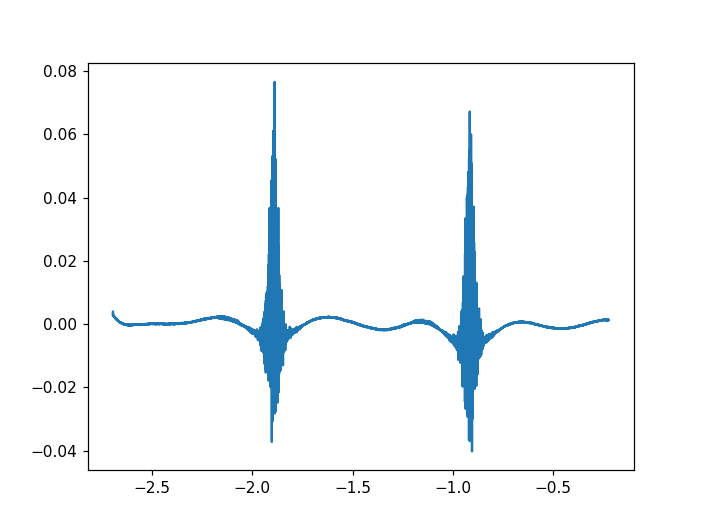

In [100]:
intfgms_arr=np.loadtxt('interferograms.txt')
a=sd.align_interferograms(intfgms_arr,order=2,flattening_order=10)
plt.figure()
plt.plot(a[1],a[0])

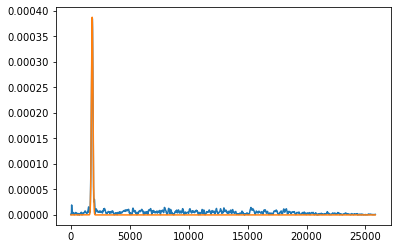

In [16]:
result=sd.fourier_xform(a,tsubtract=0,envelope=True)
plt.plot(result[0],result[1])
plt.plot(result[0],result[3])

In [17]:
a.dtype

dtype('float64')

In [58]:
from scipy.optimize import leastsq,minimize

def roll_intfgs(rs):
    
    intfgs_rolled=[]
    for r,intfg in zip(rs,all_intfgs):
        intfg_rolled=np.roll(intfg,int(r))
        intfgs_rolled.append(intfg_rolled)
        
    return np.array(intfgs_rolled)

def roll_xs(rs):
    
    xs_rolled=[]
    for r,x in zip(rs,all_xs):
        x_rolled=np.roll(x,int(r))
        xs_rolled.append(x_rolled)
        
    return np.array(xs_rolled)

def to_minimize(rs):
    
    intfgs_rolled=roll_intfgs(rs)
    
    return -np.sum(intfgs_rolled**2)

intfgs=[]
xs=[]

Ncycles = len(intfgms_arr) // 2
Nintfgms = Ncycles*2

all_xs = []
all_intfgs = []
for i in range(Ncycles):
    ys, xs = np.array(intfgms_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    all_xs.append(x); all_intfgs.append(y)
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
   
rs=minimize(to_minimize,[0]*Nintfgms).x
intfg = np.mean(roll_intfgs(rs),axis=0)
x = np.mean(roll_xs(rs),axis=0)
    


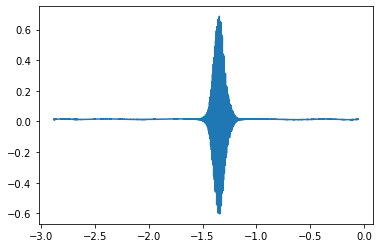

In [60]:
plt.plot(x,intfg)
#plt.xlim(-1.45,-1.3)

In [82]:
from scipy.optimize import leastsq,minimize
from scipy.interpolate import interp1d
from common import numerical_recipes as numrec
import time
intfgms_arr=np.loadtxt('interferograms.txt')
flattening_order=10

Nx=20
interp_kwargs=dict(bounds_error=False,
                   fill_value=0,
                   kind='linear')

Ncycles = len(intfgms_arr) // 2
Ncycles = np.min((20,Ncycles))
Nintfgms = Ncycles*2

all_xs = []
all_intfg_interps = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgms_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
    all_xs.append(x)
    all_intfg_interps.append( interp1d(x=x,y=y,**interp_kwargs) )
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
    
x1=np.min(all_xs)
x2=np.max(all_xs)
if dX is None: dX = x2-x1

def get_dx(x):
    
    wl = 2*dX
    return np.sin(2*np.pi*(x-x1)/wl)
    
def get_intfg_shifted(rs):
    
    intfgs_shifted=[]
    for r,x,intfg_interp in zip(rs,all_xs,all_intfg_interps):
        dx=get_dx(x)
        intfg_rolled=intfg_interp(x+r*dx)
        intfgs_shifted.append(intfg_rolled)
        
    return np.mean(intfgs_shifted,axis=0)

def get_x_shifted(rs):
    
    xs_shifted=[]
    for r,x in zip(rs,all_xs):
        dx=get_dx(x)
        xs_shifted.append(x+r*dx)
        
    return np.mean(xs_shifted,axis=0)

def to_minimize(rs):
    
    intfg_shifted=get_intfg_shifted(rs)
    
    return -np.sum(intfg_shifted**2)
   
t=time.time()
rs=minimize(to_minimize,[0]*Nintfgms,
           bounds=[(-.01,.01)]*Nintfgms,
           tol=1).x
intfg =get_intfg_shifted(rs)
x = get_x_shifted(rs)
print('Time elapsed:',time.time()-t)

interp = interp1d(x=x,y=intfg,**interp_kwargs)
xnew=x=np.linspace(x1,x1+dX,len(x))
intfg = interp(xnew)

x0*=2.403
xnew*=2.403
    


Time elapsed: 0.49567413330078125


<IPython.core.display.Javascript object>


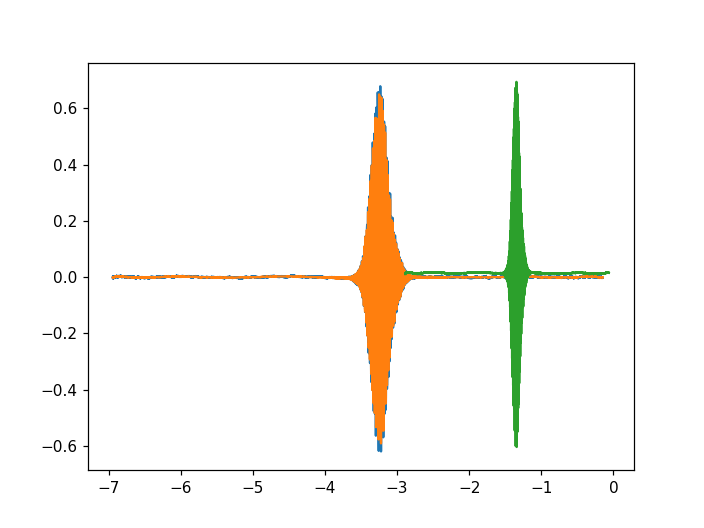

In [83]:
#plt.plot(x)
plt.figure()
plt.plot(x0,intfg0)#,x,intfg1)
plt.plot(xnew,intfg)#,x,intfg1)
#plt.xlim(-3.3,-3)
#plt.ylim(-2.7,-2)

<IPython.core.display.Javascript object>


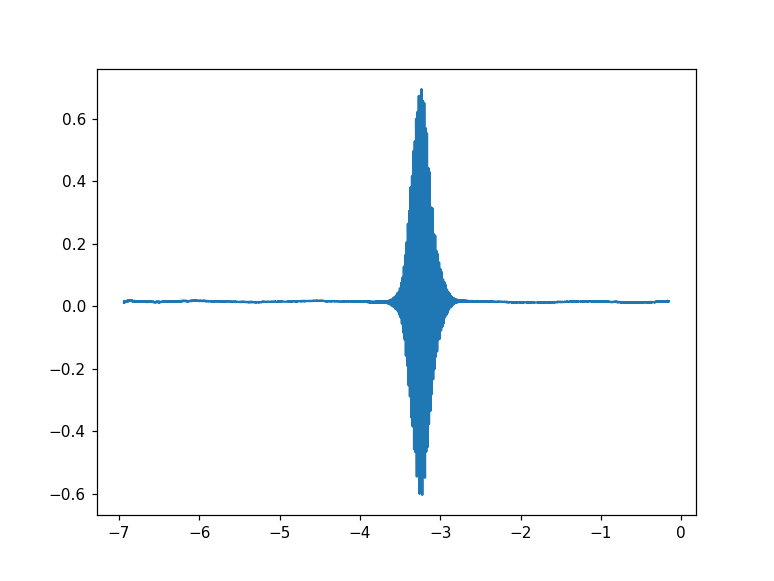

In [87]:
intfg,xnew=sd.align_interferograms(intfgms_arr,delay_calibration_factor=2.403)
plt.figure()
plt.plot(xnew,intfg)

<IPython.core.display.Javascript object>


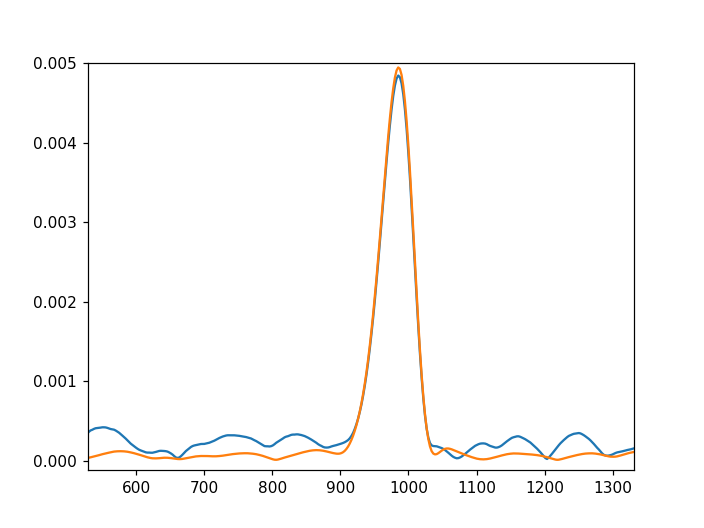

In [63]:
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result[0],result[1])

In [7]:
np.array(intfgms_arr[2 * i:2 * (i+1)])

array([], shape=(0, 46250), dtype=float64)

In [78]:
np.polyval?